Code for exploring the image segmentation abilities of phoutils for finding extended sources. 
8/16/22

In [1]:
# All the dependancies 

%matplotlib notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture, EllipticalAperture

import pandas as pd 

# for images too (also will use mpl)
import fitsio
from astropy.io import fits
#import sys 
import numpy.ma as ma
from gPhoton.reference import eclipse_to_paths
from gPhoton.coadd import zero_flag_and_edge


In [2]:
# clipping 
def centile_clip(image, centiles=(1, 99)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

def plot_centiles(array, upper_bounds):
    
    figures, axes = [], []
    
    for upper_bound in (upper_bounds):
        fig, ax = plt.subplots()
        ax.imshow(centile_clip(cnt, centiles=(0, upper_bound)))
        ax.set_title(str(upper_bound))
        figures.append(fig), axes.append(ax)
        
    return figures, axes

In [3]:
# reading in the image for the eclipse 

# info 
eclipse, band, depth, compression = 8045, "NUV", 30, "rice"
 
# reading in images 
galex_file_paths = eclipse_to_paths(
    eclipse, '/home/bekah/gphoton_working/test_data', depth, compression
)

# image to hdul 
%time hdul = fitsio.FITS(galex_file_paths[band]['image'])
%time cnt, flag, edge = [hdu.read() for hdu in hdul[1:4]]

# masking cnt image
masked_cnt = zero_flag_and_edge(cnt, flag, edge)

CPU times: user 396 µs, sys: 97 µs, total: 493 µs
Wall time: 498 µs
CPU times: user 146 ms, sys: 20.4 ms, total: 166 ms
Wall time: 164 ms


In [4]:
# subtract the background 

from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()
bkg = Background2D(masked_cnt, (50, 50), mask = edge, filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
masked_cnt -= bkg.background  # subtract the background

In [5]:
# define detection threshold (this is a 2D detection threshold
# image made w/ background RMS image, 1.5 sigma per pixel 
# noise level)

threshold = 1.5 * bkg.background_rms

In [6]:
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
kernel = make_2dgaussian_kernel(4, size=(201,201))# FWHM = 3. changed to 10 , size was 5, changed to 10 
convolved_data = convolve(masked_cnt, kernel)
#centile_clip(cnt, centiles=(0, 99.9))

<IPython.core.display.Javascript object>


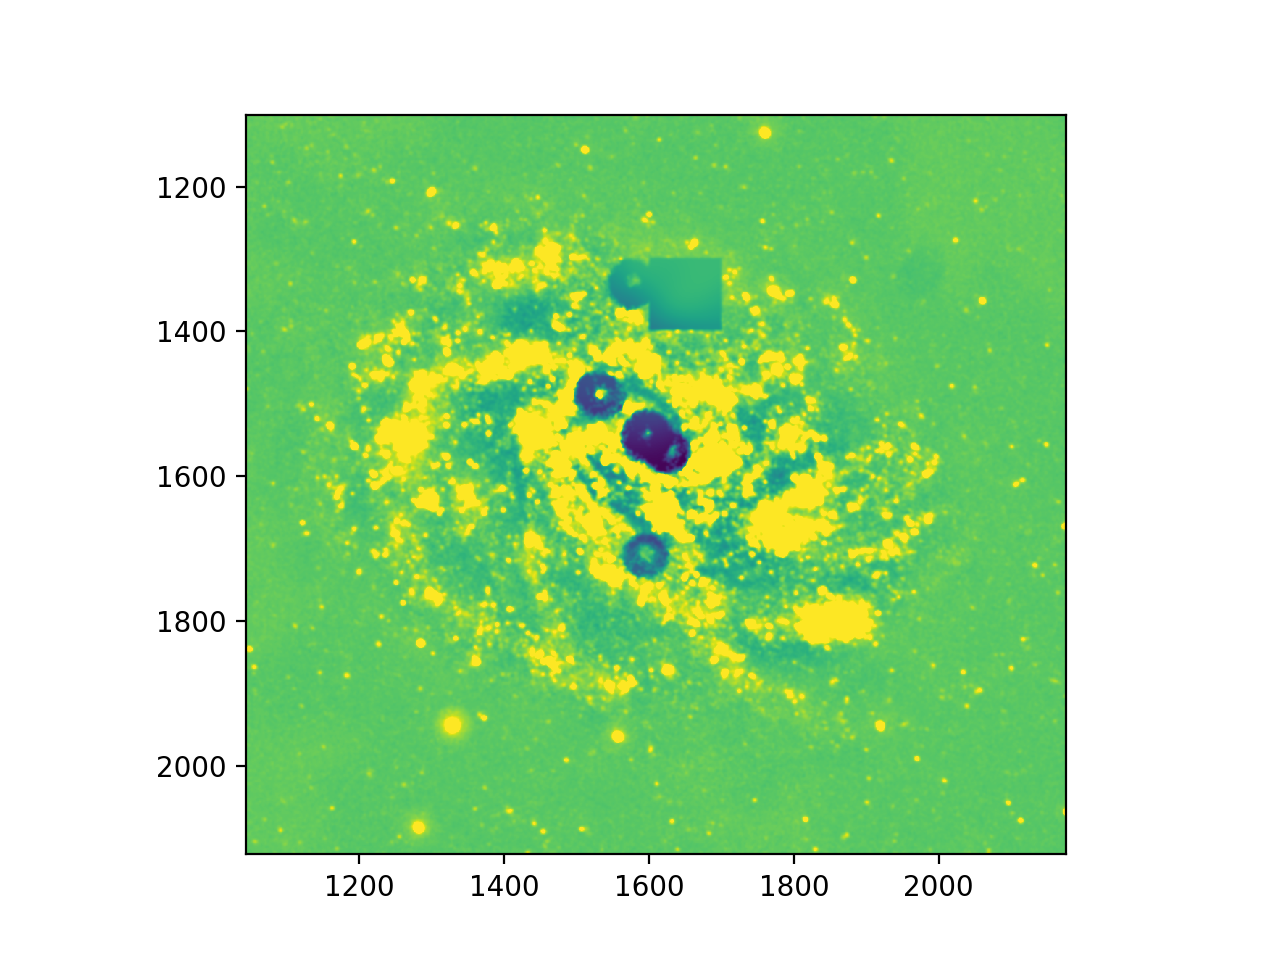

In [19]:
plt.imshow(centile_clip(convolved_data,centiles=(0,99)),interpolation='none')
#plt.imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')

In [8]:
from photutils.segmentation import detect_sources
segment_map = detect_sources(convolved_data, threshold, npixels=40)
print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (3197, 3160)
nlabels: 950
labels: [  1   2   3   4   5 ... 946 947 948 949 950]


<IPython.core.display.Javascript object>


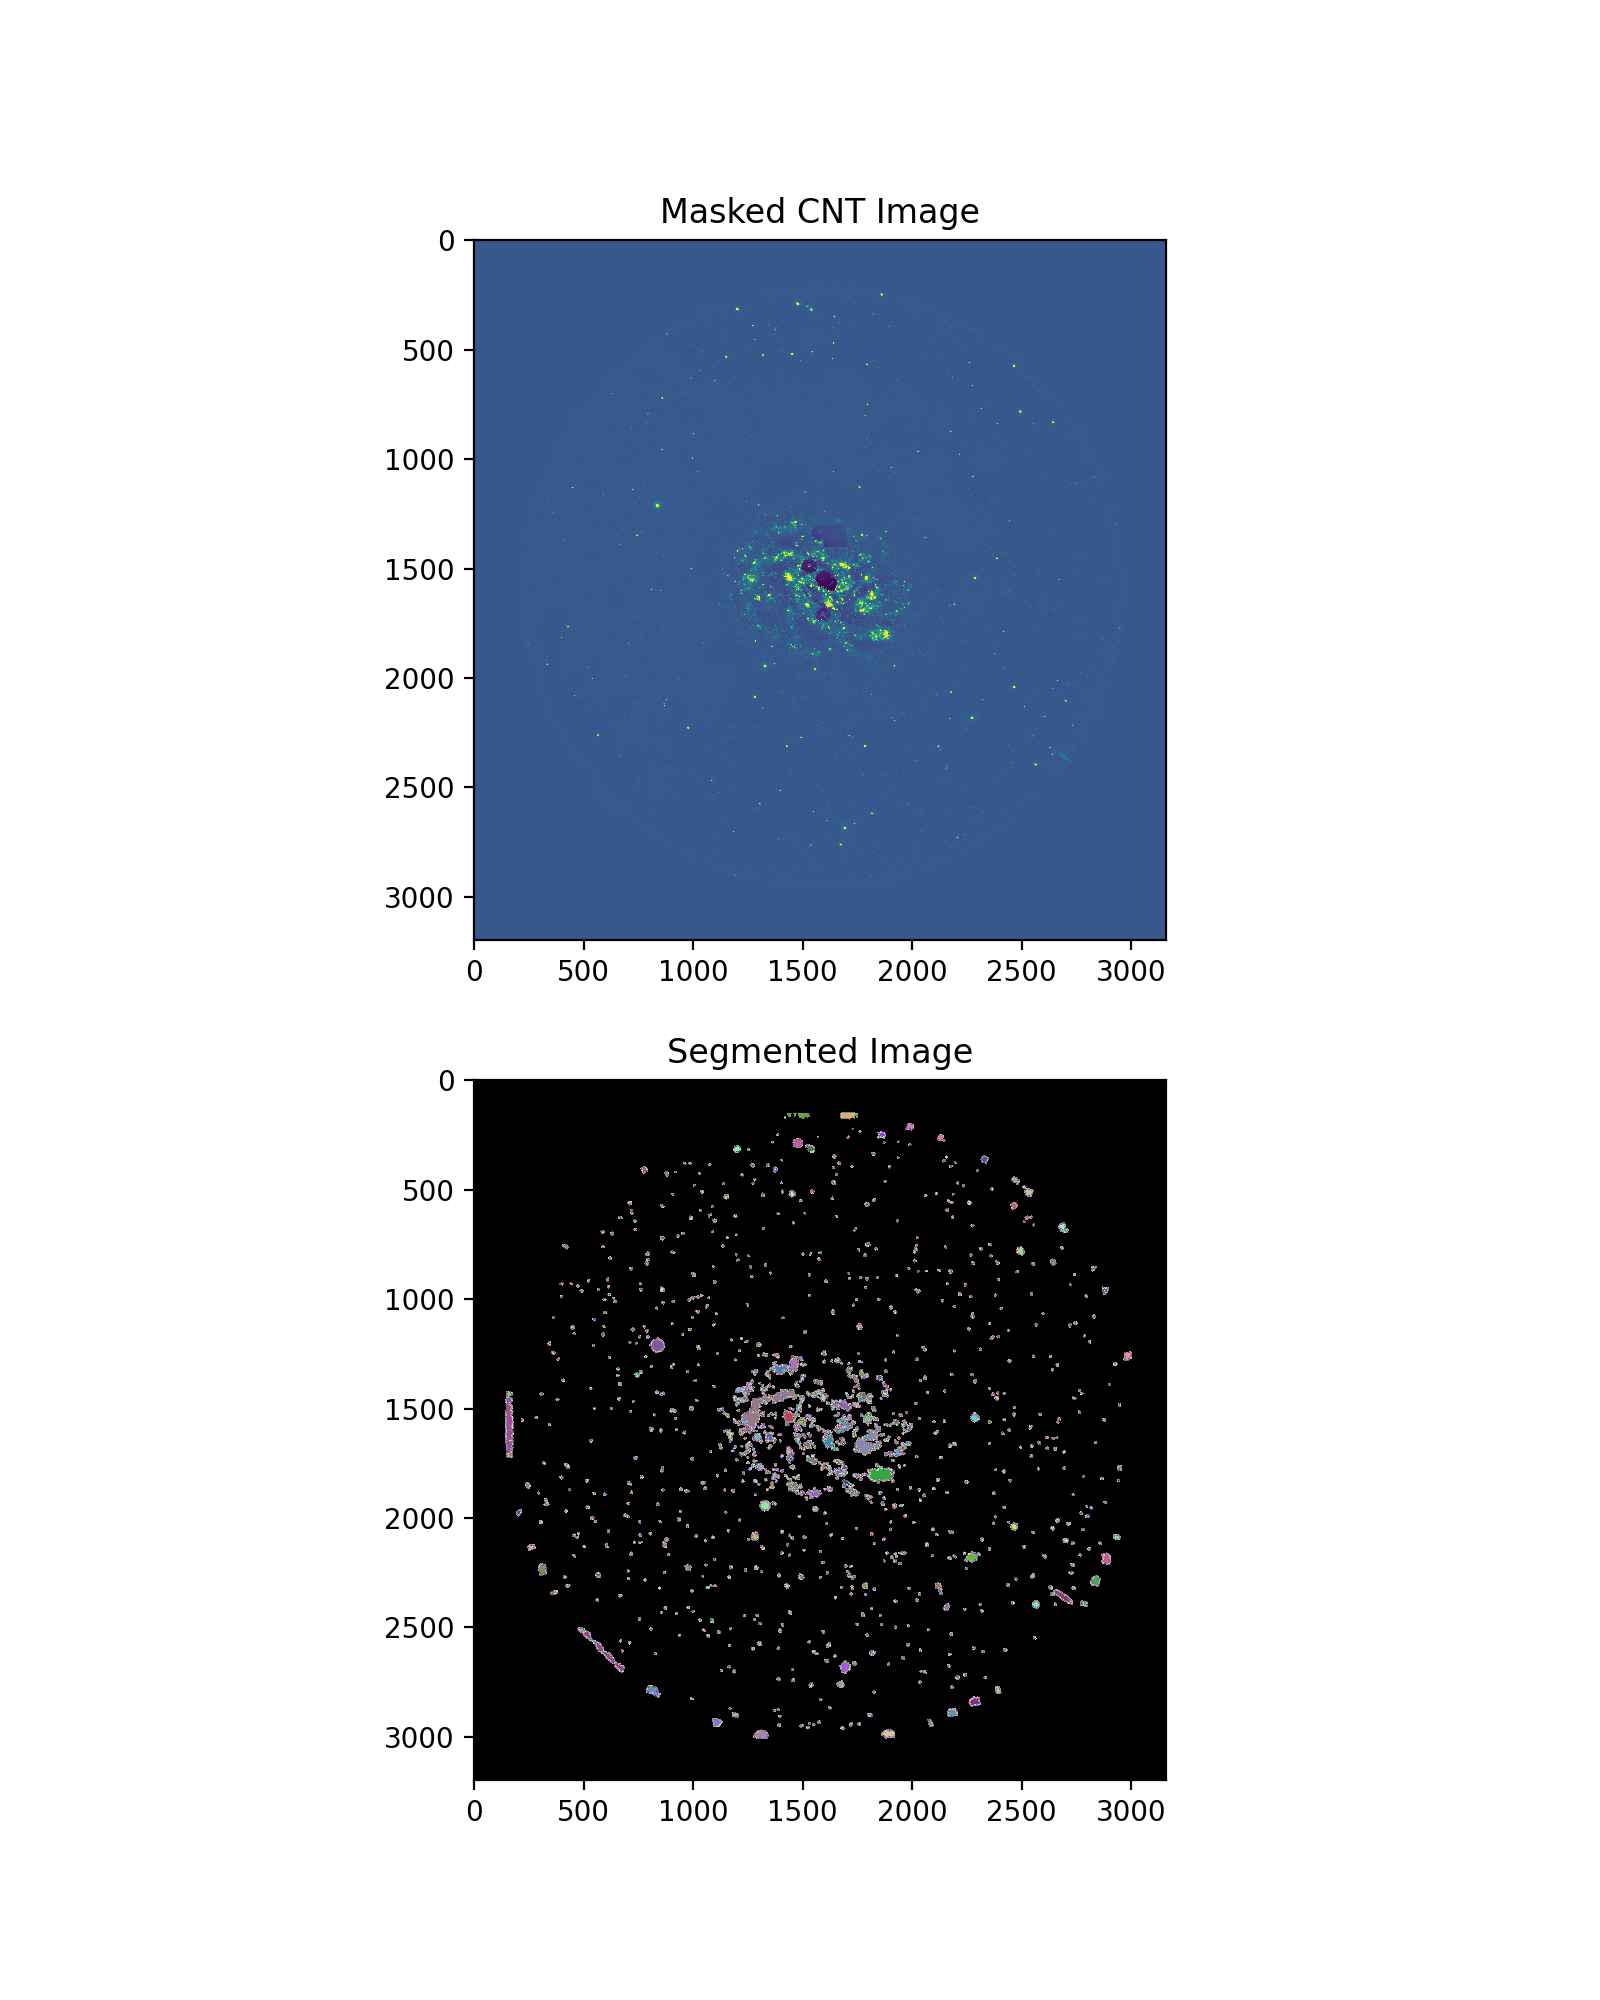

Text(0.5, 1.0, 'Segmented Image')

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (8, 10))
ax1.imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')
ax1.set_title("Masked CNT Image")
ax2.imshow(segment_map,cmap=segment_map.cmap)
ax2.set_title("Segmented Image")

In [10]:
# Source Catalog tool for measuring / finding centroids of segmented image 

from photutils.segmentation import SourceCatalog

cat = SourceCatalog(masked_cnt, segment_map, convolved_data=convolved_data)

print(cat)

<photutils.segmentation.catalog.SourceCatalog>
Length: 950
labels: [  1   2   3   4   5 ... 946 947 948 949 950]


In [11]:
tbl = cat.to_table()
# error columns are NaN because we did not input an error array 
print(tbl)

label     xcentroid      ...      kron_flux      kron_fluxerr
                         ...                                 
----- ------------------ ... ------------------- ------------
    1   1503.39805226856 ... -233.41780243910046          nan
    2  1706.613440921282 ...  1.2842649456351394          nan
    3 1419.4158403944684 ...  1.6024021973451548          nan
    4 1982.6699769617164 ...  -6.669116389646073          nan
    5 1728.1972747922186 ...   718.0649709476195          nan
    6 1762.4092338669172 ...  1174.9361132884649          nan
  ...                ... ...                 ...          ...
  944 1394.2124558963633 ...   761.3146170493424          nan
  945  1550.727843134684 ...   583.6291094446299          nan
  946 1493.9238577026756 ...  1717.9806842555927          nan
  947 1525.0319521316508 ...   871.1647782132505          nan
  948 1682.3283443196015 ...   574.0808290705272          nan
  949  1884.757842741792 ...  -67.75092968621763          nan
  950 13

# plotting elliptical Kron apertures 

from astropy.visualization import simple_norm
norm = simple_norm(masked_cnt, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(centile_clip(masked_cnt,centiles=(0,99.9)), origin='lower', cmap='viridis')
ax1.set_title('Data')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap)
ax2.set_title('Segmentation Image')
cat.plot_kron_apertures(axes=ax1, color='white', lw=1)
cat.plot_kron_apertures(axes=ax2, color='white', lw=1)
plt.show()

In [12]:
# now let's try deblending! 

from photutils.segmentation import deblend_sources

segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels=10, nlevels=15, contrast=0.001,
                               progress_bar=False)

In [13]:
# call source finder on deblended data 
from photutils.segmentation import SourceFinder

finder = SourceFinder(npixels=10, progress_bar=False)
segment_map2 = finder(convolved_data, threshold)
print(segment_map2)

<photutils.segmentation.core.SegmentationImage>
shape: (3197, 3160)
nlabels: 2543
labels: [   1    2    3    4    5 ... 2539 2540 2541 2542 2543]


In [14]:
cat_deblend = SourceCatalog(masked_cnt, segment_map2, convolved_data=convolved_data)

# plotting elliptical Kron apertures 

norm = simple_norm(masked_cnt, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(centile_clip(masked_cnt,centiles=(0,99.9)), origin='lower', cmap='viridis')
ax1.set_title('Data')
ax2.imshow(segment_map2, origin='lower', cmap=segment_map2.cmap)
ax2.set_title('Segmentation Image- Deblended')
cat_deblend.plot_kron_apertures(axes=ax1, color='white', lw=.5)
cat_deblend.plot_kron_apertures(axes=ax2, color='white', lw=.5)
plt.show()